### Stratified sampling of tweets as a function of retweet counts

The general idea is to pull out tweets for qualitative inspection that represent frequently and less-frequently re-tweeted tweets. We aim to control for the number of followers.

In [17]:
from collections import defaultdict
import csv 
import pdb
import math 
import random

import gensim
from gensim import matutils, corpora
from gensim.models.ldamodel import LdaModel

import statsmodels 
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import numpy as np
import scipy as sp
import pandas as pd
import sklearn 

import snowball

In [18]:
####
# only using tweets that contain at least one term from 
# a whitelist!
tweet_data = pd.read_csv("CancerReport-clean-whitelisted-en.txt", delimiter="\t", low_memory=False)
# pull out just the retweets
retweets = tweet_data[tweet_data["retweet"] == True]
unique_retweet_id_list = list(set(retweets["retweet_id_str"].tolist()))
# group the tweets by the tweet they are, erm, retweeting
grouped_retweets = retweets.groupby("retweet_id_str")
# then count up retweets and extract original (retweeted) text
# see code in snowball.py for doing this
orig_tweet_ids, orig_tweeter_names, orig_follower_counts, orig_tweet_texts, retweet_counts = snowball._count_up_retweets(grouped_retweets)

# primary tweets (non-retweets)
primary_tweets = tweet_data[tweet_data["retweet"] == False]
# exclude tweets that are already in our retweet set (i.e.,
# exclude 'primary' versions of retweeted tweets, because 
# these are already accounted for)
primary_tweets = primary_tweets[primary_tweets["tweet_id"].isin(orig_tweet_ids) == False]
# exclude the 10 or so tweets that are missing followers counts.
primary_tweets = primary_tweets[primary_tweets["followers_count"].isnull() == False]

# now merge tweet sets (retweeted and not)
orig_tweet_texts.extend(primary_tweets["tweet_text"].values)
# the assumption is that these have *not* been retweeted at all!
# @TODO verify?
retweet_counts.extend([0]*primary_tweets.shape[0])
orig_follower_counts.extend(primary_tweets["followers_count"])
orig_tweeter_names.extend(primary_tweets["screen_name"])
orig_tweet_ids.extend(primary_tweets["tweet_id"])

In [19]:
ranges = list(range(0, 100, 10))
percentile_follower_counts = [
    int(np.percentile(orig_follower_counts, p)) for p in ranges]

Below I show the follower count for each decile

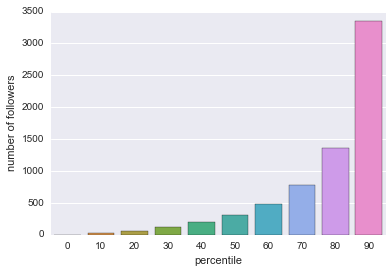

In [20]:
sns.barplot(x=ranges, y=percentile_follower_counts)
plt.xlabel("percentile")
plt.ylabel("number of followers");

Now calculate each user's percentile (we round to place them in the nearest ten bin).

In [21]:
user_percentiles = []
for user_follower_count in orig_follower_counts:
    
    user_percentiles.append(
        int(math.floor(min(sp.stats.percentileofscore(
            orig_follower_counts, user_follower_count) / 10.0, 9.9)) * 10))

Sanity check

In [22]:
list(zip(user_percentiles[0:10], orig_follower_counts))

[(50, 467.0),
 (80, 1899.0),
 (0, 14.0),
 (50, 414.0),
 (80, 2258.0),
 (80, 3008.0),
 (20, 120.0),
 (10, 28.0),
 (70, 1187.0),
 (50, 407.0)]

Now we want to get a sense for what constitutes "popular" and "unpopular" tweets within the respective percentiles. 

In [23]:
def get_retweet_counts_with_follower_percentile(retweet_counts, user_percentiles, percentile):
    retweet_counts_for_percentile = []
    for idx, retweet_count in enumerate(retweet_counts):
        if user_percentiles[idx] == percentile:
           retweet_counts_for_percentile.append(retweet_counts[idx]) 
    return retweet_counts_for_percentile

In [24]:
retweet_counts_for_percentiles = [
    get_retweet_counts_with_follower_percentile(
            retweet_counts, user_percentiles, p) for p in ranges]

In [25]:
set(user_percentiles)

{0, 10, 20, 30, 40, 50, 60, 70, 80, 90}

In [26]:
conditional_percentiles = []
for idx, retweet_count in enumerate(retweet_counts):
    #if idx % 100 == 0:
    #    print("on tweet %s out of %s" % (idx, len(retweet_counts)))
    cur_follower_percentile = int(user_percentiles[idx]/10)
    
    percentile_retweet_counts = retweet_counts_for_percentiles[cur_follower_percentile]
    
    
    # use the follower percentile to index into conditional 
    # percentiles
    conditional_percentile = int(math.floor(min(sp.stats.percentileofscore(
        percentile_retweet_counts, retweet_counts[idx])/10.0, 9.9)) * 10)
    conditional_percentiles.append(conditional_percentile)

In [27]:
d = dict({"tweet": orig_tweet_texts, "conditional_percentile": conditional_percentiles,
           "follower_count": orig_follower_counts, "tweet_id":orig_tweet_ids, 
           "absolute_retweet_count":retweet_counts, 
           "follower_percentile":user_percentiles})
df = pd.DataFrame(d)

In [28]:
df.head()

,absolute_retweet_count,conditional_percentile,follower_count,follower_percentile,tweet,tweet_id
0,1,80,467,50,#news: British girl dies after cervical cancer...,4.477687e+09
1,1,80,1899,80,"RT @SamValley We Wish You a Lucky Mammogram, a...",6.064162e+09
2,1,90,14,0,This week’s podcast: a new antibiotic for C. d...,3.364325e+16
3,1,80,414,50,i eat more pussy that cervical cancer.,4.823603e+16
4,1,80,2258,80,“@STRETCHMARKILLA: If you a dude and wear ankl...,7.615192e+16


Now sample!

/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


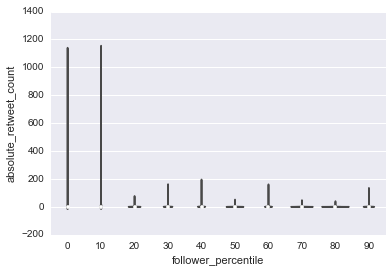

In [29]:
ax = sns.violinplot(x="follower_percentile", y="absolute_retweet_count", data=df);


In [30]:
n_to_sample = 20 # this many popular/unpopular tweets
decile_d = {}
decile_samples = []
for percentile in ranges:
    # popular/unpopular tweets in this decile
    #decile_d = {}
    percentile_tweets = df[df["follower_percentile"] == percentile]
    
    popular_tweets = percentile_tweets.sort_values(["conditional_percentile"], ascending=[0])[:n_to_sample]
    unpopular_tweets = percentile_tweets.sort_values(["conditional_percentile"], ascending=[1])[:n_to_sample]
    

    decile_d["popular"] = popular_tweets
    decile_d["unpopular"] = unpopular_tweets    
    decile_samples.append(decile_d)


In [31]:
for i, decile in enumerate(decile_samples):
    decile["popular"].to_csv("retweet-sampling/%s-popular-tweets.csv" % i)
    decile["unpopular"].to_csv("retweet-sampling/%s-unpopular-tweets.csv" % i)
    